In [1]:
import pandas as pd
import numpy as np

csv_file_path = 'fake_transactional_data_24.csv'
df = pd.read_csv(csv_file_path)

def count_daily(shop):
    data = df[df['to_randomly_generated_account'] == shop]

    #按天汇总
    data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'], format='%d/%m/%Y')

    # 设置日期列为索引
    data.set_index('not_happened_yet_date', inplace=True)

    # 按天汇总交易额并输出
    data_daily = data['monopoly_money_amount'].resample('D').sum().reset_index()
    data_daily.to_csv(f'{shop}_daily_transactions.csv', index=False)

In [2]:
# 加载数据
count_daily('JEWLLERY_SHOP')
path = 'JEWLLERY_SHOP_daily_transactions.csv'
data = pd.read_csv(path)
data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'], format='%Y-%m-%d')
data.set_index('not_happened_yet_date', inplace=True)

C:\Users\12147\AppData\Local\Temp\ipykernel_20988\3160433762.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'], format='%d/%m/%Y')


In [3]:
#Data pre-processing
# Find the zero value and replace it with the average of the day before and the day after
zero_value_date = data.index[data['monopoly_money_amount'] == 0]
if not zero_value_date.empty:
    for zero_date in zero_value_date:
        day_before = zero_date - pd.Timedelta(days=1)
        day_after = zero_date + pd.Timedelta(days=1)
        average_income = data.loc[[day_before, day_after], 'monopoly_money_amount'].mean()
        data.loc[zero_date, 'monopoly_money_amount'] = average_income

# Confirm the changes
data.head()


,monopoly_money_amount
not_happened_yet_date,
2025-01-01,190.0
2025-01-02,271.0
2025-01-03,214.0
2025-01-04,95.0
2025-01-05,228.0


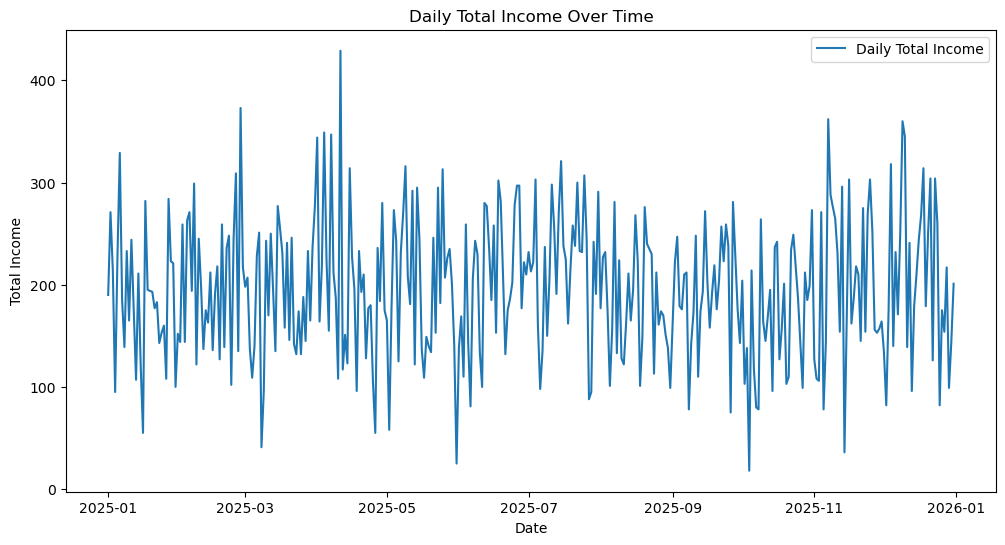

In [4]:
# Plot the daily total income
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['monopoly_money_amount'], label='Daily Total Income')
plt.title('Daily Total Income Over Time')
plt.xlabel('Date')
plt.ylabel('Total Income')
plt.legend()
plt.show()

In [5]:
#ADF test
# Perform Augmented Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(data['monopoly_money_amount'])

adf_result

(-17.820927021106417,
 3.161262489788795e-30,
 0,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 3911.8943354294934)

     lb_stat  lb_pvalue
10  9.046241   0.527721


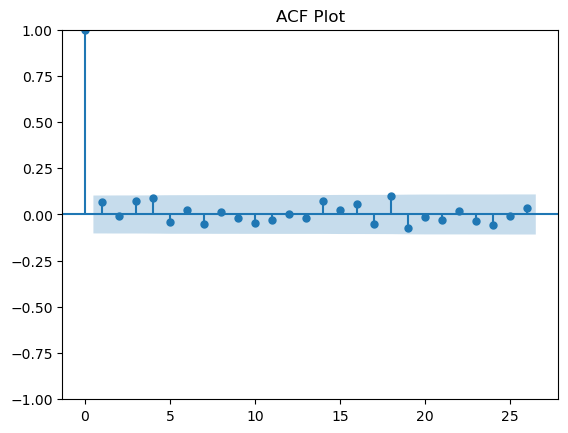

In [6]:
#Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(data, lags=[10], return_df=False)
print(lb_result)

# ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data)
plt.title('ACF Plot')
plt.show()

是白噪声

平稳性检验小于5%

In [7]:
# # 一阶差分
# data_diff = data.diff().dropna()

# #ADF test
# # Perform Augmented Dickey-Fuller test to check for stationarity
# adf_result = adfuller(data_diff['monopoly_money_amount'])

# adf_result


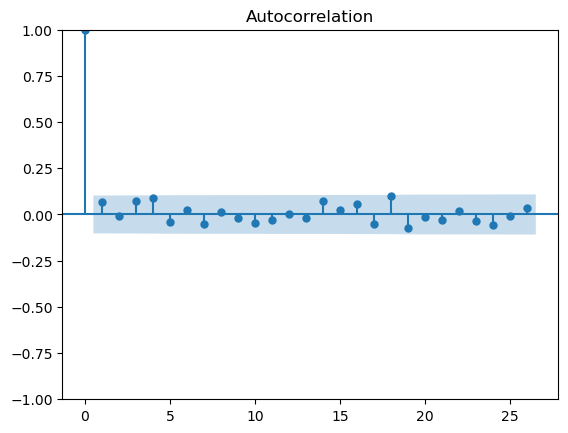

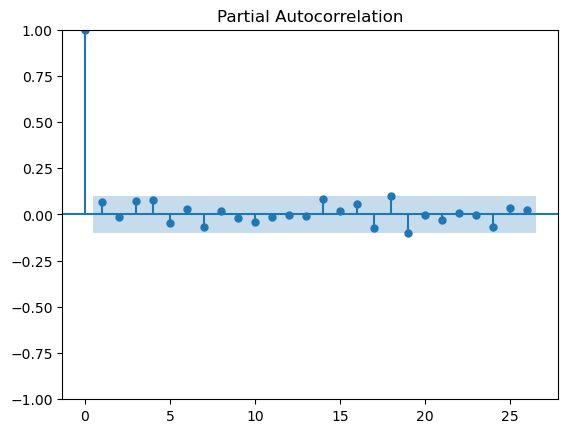

In [8]:
# 绘制ACF和PACF图
#plot_acf(data_diff)
plot_acf(data)
plt.show()

#plot_pacf(data_diff)
plot_pacf(data)
plt.show()

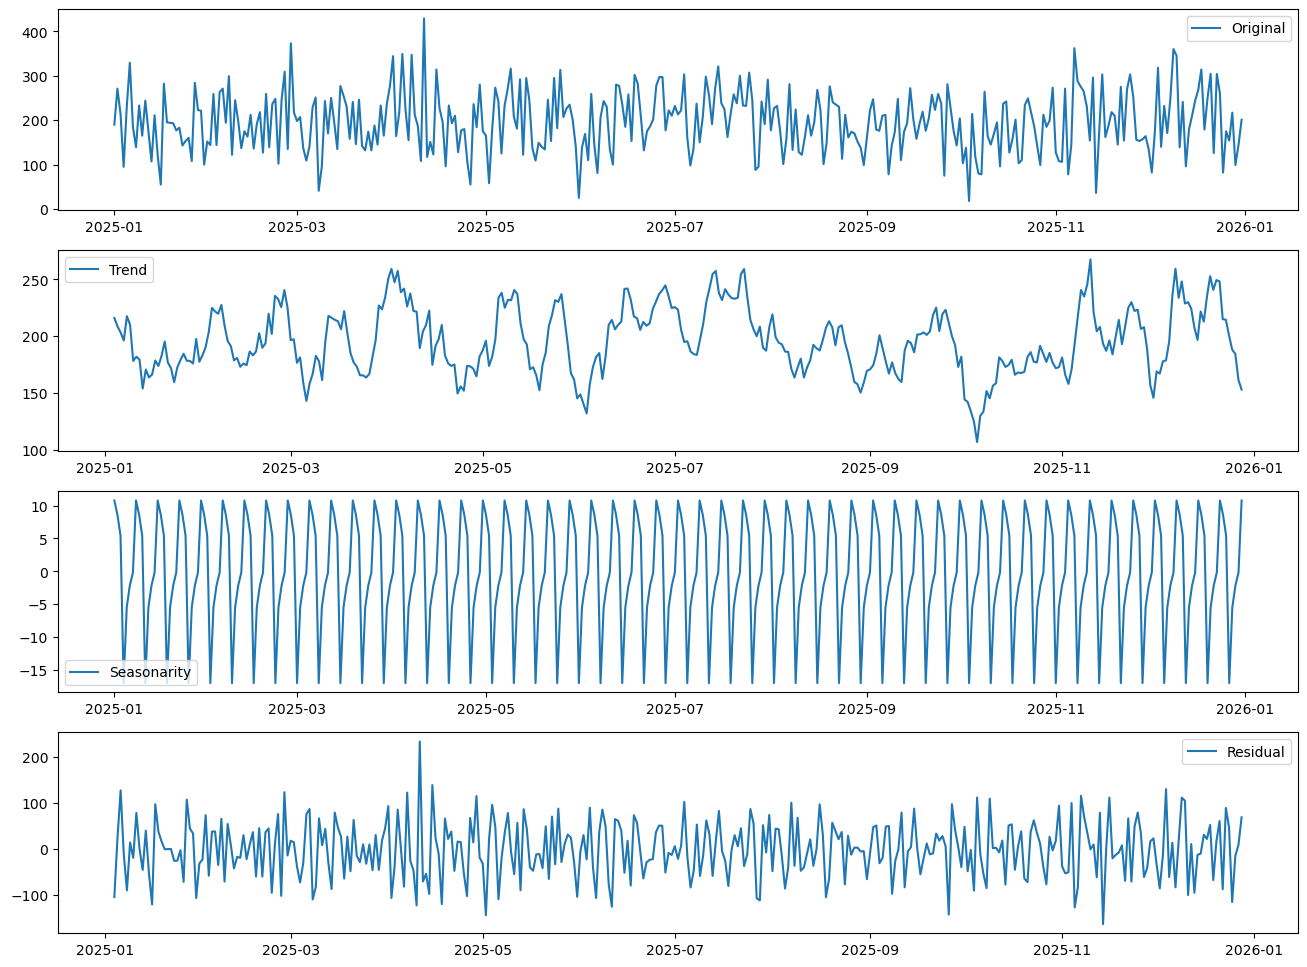

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF


def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()


# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
#                                  index_col='report_date', date_parser=dateparse)

decomposing(data)

从第三幅图能看出序列具有严格的季节性，使用SARIMA模型

先不用SARIMA，而是手动对季节差分，之后使用ARIMA

D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:             monopoly_money_amount   No. Observations:                  292
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1609.972
Date:                           Wed, 06 Mar 2024   AIC                           3225.943
Time:                                   23:12:03   BIC                           3236.901
Sample:                               01-01-2025   HQIC                          3230.336
                                    - 10-19-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0593      0.062      0.953      0.341      -0.063       0.181
ma.S.L7       -0.9953      0.283     -3.521

<Figure size 1200x400 with 0 Axes>

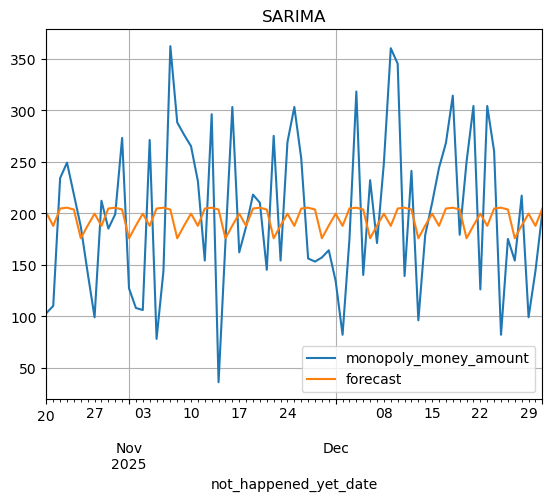

In [10]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
def version_sarima(ts):
    """
    SARIMA（statsmodels）
    """
    # 不提前做季节差分，让D=1

    # 周期大小
    periods = 7

    # 数据拆分
    train, test = train_test_split(ts, train_size=0.8)

    # 模型训练
    d, D = 0, 1
    p, q, P, Q= 0,1,0,1
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, periods)).fit(disp=-1)
    print(model.summary())

    # 拟合结果
    fitted = model.fittedvalues

    # 模型预测
    fcst = model.forecast(test.shape[0])

    # 模型评估
    rmse = np.sqrt(mean_squared_error(test, fcst))
    print('RMSE: %.4f' % rmse)

    # 可视化
    plt.figure(figsize=(12, 4))
    test.plot(label='Ads')
#     fitted.plot(label='fitted')
    fcst.plot(label='forecast')
    plt.legend()
    plt.grid(True)
    plt.title('SARIMA')
    # 导出图形到文件，例如保存为PNG格式
    plt.savefig('a_cafe_result.png')
    plt.show()
    
version_sarima(data)